# Setting everything up

In [3]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.special import hyp2f1, expm1
from scipy.integrate import nquad, quad
from scipy.interpolate import interp1d, RegularGridInterpolator
from joblib import Parallel, delayed
import mpmath
import os
import sys
from matplotlib import pyplot as plt
from mpmath import quad as mpquad
import pandas as pd
from tqdm import tqdm
import time
import cosmolopy.distance as cd

mpmath.mp.dps = 200 # sets a higher precision, mathematica does this automatically

In [4]:
blazar_egb = np.loadtxt("/Users/matias/Downloads/blazar_data/known_components/blazar_egb.csv", delimiter=",")
dNdGamma_actual = np.loadtxt("/Users/matias/Downloads/blazar_data/old_digitizations/topRightFig.csv", delimiter=",")
NF100_actual = np.loadtxt("/Users/matias/Downloads/blazar_data/old_digitizations/botLeftFig.csv", delimiter=",")
NF_actual = np.loadtxt("/Users/matias/Downloads/blazar_data/old_digitizations/botRightFig.csv", delimiter=",")
dNdz_actual = np.loadtxt("/Users/matias/Downloads/blazar_data/old_digitizations/topLeftFig.csv", delimiter=",")
dNdL_actual = np.loadtxt("/Users/matias/Downloads/blazar_data/old_digitizations/dNdL.csv", delimiter=",")
dNdz_ple_qu = np.loadtxt("/Users/matias/Downloads/blazar_data/old_digitizations/dNdz_ple_qu.csv", delimiter=",")
dNdz_pde_qu = np.loadtxt("/Users/matias/Downloads/blazar_data/old_digitizations/dNdz_pde_qu.csv", delimiter=",")
dNdz_ldde_qu = np.loadtxt("/Users/matias/Downloads/blazar_data/old_digitizations/dNdz_ldde_qu.csv", delimiter=",")
dNdG_ple_qu = np.loadtxt("/Users/matias/Downloads/blazar_data/old_digitizations/dNdG_ple_qu.csv", delimiter=",")
dNdG_pde_qu = np.loadtxt("/Users/matias/Downloads/blazar_data/old_digitizations/dNdG_pde_qu.csv", delimiter=",")
dNdG_ldde_qu = np.loadtxt("/Users/matias/Downloads/blazar_data/old_digitizations/dNdG_ldde_qu.csv", delimiter=",")
dNdL_ple_qu = np.loadtxt("/Users/matias/Downloads/blazar_data/old_digitizations/dNdL_ple_qu.csv", delimiter=",")
dNdL_pde_qu = np.loadtxt("/Users/matias/Downloads/blazar_data/old_digitizations/dNdL_pde_qu.csv", delimiter=",")
dNdL_ldde_qu = np.loadtxt("/Users/matias/Downloads/blazar_data/old_digitizations/dNdL_ldde_qu.csv", delimiter=",")
fermi_sensitivity = np.loadtxt("/Users/matias/Downloads/blazar_data/fermiDetectionSensitivity.csv", delimiter=",")
fermi_sensitivity_qu = np.loadtxt("/Users/matias/Downloads/blazar_data/fermiSensitivityQu.csv", delimiter=",")

In [5]:
file_path = "/Users/matias/Downloads/blazar_data/old_digitizations/dNdz_data.csv" 
df = pd.read_csv(file_path, header=None, names=["x", "y", "index", "position"])
df['position'] = df['position'].str.strip()

mid_points = df[df['position'] == 'mid']
left_points = df[df['position'] == 'left']
right_points = df[df['position'] == 'right']
upper_points = df[df['position'] == 'upper']
lower_points = df[df['position'] == 'lower']

dNdz_x_vals = np.array(mid_points['x'])
dNdz_y_vals = np.array(mid_points['y'])

x_err_left = dNdz_x_vals - left_points['x'].values
x_err_right = right_points['x'].values - dNdz_x_vals
y_err_upper = upper_points['y'].values - dNdz_y_vals
y_err_lower = dNdz_y_vals - lower_points['y'].values

dNdz_x_err = [x_err_left, x_err_right]
dNdz_y_err = [y_err_lower, y_err_upper]

In [6]:
file_path = "/Users/matias/Downloads/blazar_data/old_digitizations/dNdGamma_data.csv" 
df = pd.read_csv(file_path, header=None, names=["x", "y", "index", "position"])
df['position'] = df['position'].str.strip()

mid_points = df[df['position'] == 'mid']
left_points = df[df['position'] == 'left']
right_points = df[df['position'] == 'right']
upper_points = df[df['position'] == 'upper']
lower_points = df[df['position'] == 'lower']

dNdGamma_x_vals = np.array(mid_points['x'])
dNdGamma_y_vals = np.array(mid_points['y'])

x_err_left = dNdGamma_x_vals - left_points['x'].values
x_err_right = right_points['x'].values - dNdGamma_x_vals
y_err_upper = upper_points['y'].values - dNdGamma_y_vals
y_err_lower = dNdGamma_y_vals - lower_points['y'].values

dNdGamma_x_err = [x_err_left, x_err_right]
dNdGamma_y_err = [y_err_lower, y_err_upper]

In [7]:
file_path = "/Users/matias/Downloads/blazar_data/old_digitizations/dNdL_data.csv" 
df = pd.read_csv(file_path, header=None, names=["x", "y", "index", "position"])
df['position'] = df['position'].str.strip()

mid_points = df[df['position'] == 'mid']
left_points = df[df['position'] == 'left']
right_points = df[df['position'] == 'right']
upper_points = df[df['position'] == 'upper']
lower_points = df[df['position'] == 'lower']

dNdL_x_vals = np.array(mid_points['x'])
dNdL_y_vals = np.array(mid_points['y'])

x_err_left = dNdL_x_vals - left_points['x'].values
x_err_right = right_points['x'].values - dNdL_x_vals
y_err_upper = upper_points['y'].values - dNdL_y_vals
y_err_lower = dNdL_y_vals - lower_points['y'].values

dNdL_x_err = [x_err_left, x_err_right]
dNdL_y_err = [y_err_lower, y_err_upper]

In [8]:
# Fixing discontinuities in the digitized plot
fermi_sensitivity_func = interp1d(
    fermi_sensitivity[:, 0], fermi_sensitivity[:, 1], kind="linear", fill_value="extrapolate"
)

def new_fermi_func(x):
    if x < 2.1e-10:
        return 0
    value = fermi_sensitivity_func(x)
    if x > 1e-6 or value > 1:
        return 1
    return value


# doing a similar thing for Qu's fermi function

fermi_sensitivity_func_qu = interp1d(
    fermi_sensitivity_qu[:, 0],  fermi_sensitivity_qu[:, 1], kind='linear', fill_value="extrapolate"
)

# Define the newFermiFuncQu function
def new_fermi_func_qu(x):
    if x < 1e-10:
        return 0
    value = fermi_sensitivity_func_qu(x)
    if x > 1e-8 or value > 1:
        return 1
    return value

In [86]:
cd.diff_comoving_volume(1,**cosmo)

370459539999.0842

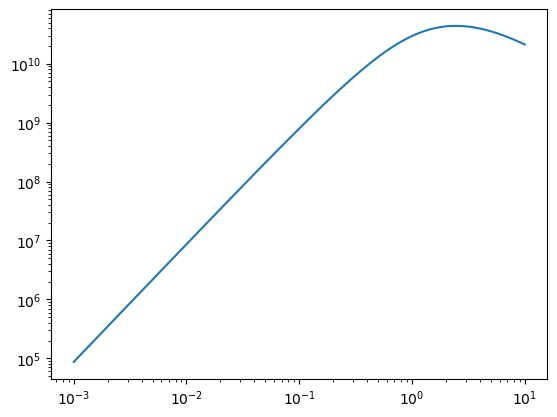

In [83]:
z_arr = np.logspace(-3,1,100)
dvdz_arr = np.array([cd.diff_comoving_volume(z, **cosmo) for z in z_arr])
plt.plot(z_arr,dvdz_arr)
plt.xscale('log')
plt.yscale('log')

In [9]:
# Constants
cosmo = {'omega_M_0' : 0.3, 'omega_lambda_0' : 0.7, 'omega_k_0': 0, 'h' : 0.698}
Mpc = 3.09e24  # cm
c = 2.9972e5  # km/s
Omega_l = 0.7
Omega_m = 0.3  # from 1501.05301
H0 = 67.6*Mpc**-1  # km/s/Mpc
dOmega = 4 * np.pi
dH = c / H0  # cm

energies = np.logspace(-1, 12, 300)  # from GCascade

# Functions for cosmological calculations
def e(z):
    return np.sqrt(Omega_l + Omega_m * (1 + z)**3)

def dc(z):
    return dH / np.sqrt(Omega_l) * (
        (1 + z) * hyp2f1(1 / 3, 1 / 2, 4 / 3, -((1 + z)**3 * Omega_m / Omega_l))
        - hyp2f1(1 / 3, 1 / 2, 4 / 3, -(Omega_m / Omega_l))
    )

def dl(z):
    return (1 + z) * dc(z)

def dVdz(z):
    return dOmega * (c / H0) * (dc(z)**2) * (1 / e(z))

In [10]:
# Load the digitized data (replace with the actual file paths)
redshift002Arr = np.loadtxt("/Users/matias/Downloads/blazar_data/finkeEBL/redshift002.csv", delimiter=",")
redshift05Arr = np.loadtxt("/Users/matias/Downloads/blazar_data/finkeEBL/redshift05.csv", delimiter=",")
redshift1Arr = np.loadtxt("/Users/matias/Downloads/blazar_data/finkeEBL/redshift1.csv", delimiter=",")
redshift2Arr = np.loadtxt("/Users/matias/Downloads/blazar_data/finkeEBL/redshift2.csv", delimiter=",")
redshift3Arr = np.loadtxt("/Users/matias/Downloads/blazar_data/finkeEBL/redshift3.csv", delimiter=",")

# Convert TeV to GeV (by multiplying by 1000)
redshift002Arr[:, 0] *= 1000
redshift05Arr[:, 0] *= 1000
redshift1Arr[:, 0] *= 1000
redshift2Arr[:, 0] *= 1000
redshift3Arr[:, 0] *= 1000

# Create interpolating functions for each redshift
redshift002 = interp1d(redshift002Arr[:, 0], redshift002Arr[:, 1], kind='linear', bounds_error=False, fill_value="extrapolate")
redshift05 = interp1d(redshift05Arr[:, 0], redshift05Arr[:, 1], kind='linear', bounds_error=False, fill_value="extrapolate")
redshift1 = interp1d(redshift1Arr[:, 0], redshift1Arr[:, 1], kind='linear', bounds_error=False, fill_value="extrapolate")
redshift2 = interp1d(redshift2Arr[:, 0], redshift2Arr[:, 1], kind='linear', bounds_error=False, fill_value="extrapolate")
redshift3 = interp1d(redshift3Arr[:, 0], redshift3Arr[:, 1], kind='linear', bounds_error=False, fill_value="extrapolate")

# Define level sets
levelsets = [
    (0.02, redshift002),
    (0.5, redshift05),
    (1.0, redshift1),
    (2.0, redshift2),
    (3.0, redshift3)
]


# Generate example points for interpolation
examplePoints = []
for z, f in levelsets:
    for energy in energies:
        examplePoints.append([energy, z, f(energy)])
examplePoints = np.array(examplePoints)

# Define the optical depth function as a 2D interpolation
opticalDepth = RegularGridInterpolator(
    (energies, [levelset[0] for levelset in levelsets]),
    np.array([levelset[1](energies) for levelset in levelsets]).T,
    method='linear', bounds_error=False, fill_value=None
)

# Define the exponential optical depth function
def expOpticalDepth(En, z):
    zValue = max(z, 0.02)  # Handle low redshifts
    optical_depth = opticalDepth((En, zValue))
    value = np.exp(-optical_depth)
    return min(value, 1)  # Cap the value at 1


In [11]:
def phi_LDDE(Lext, Gammaext, zext):
    AParam = 1.96e-9 * Mpc**-3
    Gamma1 = 0.5
    Gamma2 = 1.83
    p1star = 3.39
    Tau = 3.16
    p2star = -4.96
    Delta = 0.64
    zstar = 1.25
    Alpha = 7.23e-2
    MuStar = 2.22
    Beta = 0.1
    L0 = 1.05e48  # erg/s
    Sigma = 0.28

    def zc(L):
        return zstar * (L / 1e48) ** Alpha

    def p1(L):
        return p1star + Tau * (np.log10(float(L)) - 46)

    def p2(L):
        return p2star + Delta * (np.log10(float(L)) - 46)

    def evo(L, z):
        return (((1 + z) / (1 + zc(L))) ** -p1(L) + ((1 + z) / (1 + zc(L))) ** -p2(L)) ** -1

    def MuFunction(L):
        return MuStar + Beta * (np.log10(float(L)) - 46)

    def Phi0(L, Gamma):
        return AParam / (np.log(10) * L) * (((L / L0) ** Gamma1 + (L / L0) ** Gamma2) ** -1) * \
            np.exp(-(((Gamma - MuFunction(L)) ** 2 )/ (2 * Sigma ** 2)))

    def Phi(L, Gamma, z):
        return Phi0(L, Gamma) * evo(L, z)

    return Phi(Lext, Gammaext, zext)

# PLE Function
def phi_PLE(Lext, Gammaext, zext):
    AParam = 0.193e-9 * Mpc**-3
    Gamma1 = 3.19
    Gamma2 = 1.14
    kstar = 4.41
    Tau = 0.91
    Xi = -0.43
    MuStar = 2.22
    Beta = 0.1
    L0 = 8.75e46  # erg/s
    Sigma = 0.28

    def kd(L):
        return kstar + Tau * (np.log10(float(L)) - 46)

    def lEvo(L, z):
        return L / ((1 + z) ** kd(L) * np.exp(z / Xi))

    def MuFunction(L, z):
        return MuStar + Beta * (np.log10(float(lEvo(L, z))) - 46)

    def Phi(L, Gamma, z):
        return AParam / (np.log(10) * lEvo(L, z)) * ((lEvo(L, z) / L0) ** Gamma1 + (lEvo(L, z) / L0) ** Gamma2) ** -1 * \
               np.exp(-((Gamma - MuFunction(L, z)) ** 2 / (2 * Sigma ** 2)))

    return Phi(Lext, Gammaext, zext)

# PDE Function
def phi_PDE(Lext, Gammaext, zext):
    AParam = 0.0122e-9 * Mpc**-3
    Gamma1 = 2.8
    Gamma2 = 1.26
    kstar = 12.14
    Tau = 2.79
    Xi = -0.15
    MuStar = 2.22
    Beta = 0.1
    L0 = 0.44e48  # erg/s
    Sigma = 0.28

    def kd(L):
        return kstar + Tau * (np.log10(L) - 46)

    def evo(L, z):
        return (1 + z) ** kd(L) * np.exp(z / Xi)

    def MuFunction(L):
        return MuStar + Beta * (np.log10(L) - 46)

    def Phi0(L, Gamma):
        return AParam / (np.log(10) * L) * ((L / L0) ** Gamma1 + (L / L0) ** Gamma2) ** -1 * \
               np.exp(-((Gamma - MuFunction(L)) ** 2 / (2 * Sigma ** 2)))

    def Phi(L, Gamma, z):
        return Phi0(L, Gamma) * evo(L, z)

    return Phi(Lext, Gammaext, zext)


In [12]:
def phi_PLE_qu(Lext, Gamma_ext, zext):
    AParam = (10**-6.39) * Mpc**-3
    Gamma1 = 0.62
    Gamma2 = 1.92
    L0 = 10**44.72  # erg/s
    kstar = 4.23
    tau = 0.7
    xi = -0.43
    mustar = 1.93
    beta = 0.066
    sigma = 0.23

    # Helper functions
    def kd(L):
        return kstar + tau * (np.log10(L) - 46)

    def lEvo(L, z):
        return L / ((1 + z)**kd(L) * np.exp(z / xi))

    def mu_function(L, z):
        return mustar + beta * (np.log10(lEvo(L, z)) - 46)

    def Phi(L, Gamma, z):
        Levo = lEvo(L, z)
        mu = mu_function(Levo, z)
        return (AParam / (np.log(10) * Levo) * 
                ((Levo / L0)**Gamma1 + (Levo / L0)**Gamma2)**-1 * 
                np.exp(-((Gamma - mu)**2 / (2 * sigma**2))))

    return Phi(Lext, Gamma_ext, zext)


def phi_LDDE_qu(Lext, Gamma_ext, zext):
    # Constants
    AParam = (10**-5.32) * Mpc**-3
    Gamma1 = 1.37
    Gamma2 = 0.51
    L0 = 10**44.28  # erg/s
    p1star = 4.81
    tau = -1.6
    p2star = -8.27
    delta = 0.64
    zstar = 0.94
    alpha = 0.14
    mustar = 1.93
    beta = 0.083
    sigma = 0.23

    # Helper functions
    def zc(L):
        return zstar * (L / 10**48)**alpha

    def p1(L):
        return p1star + tau * (np.log10(L) - 46)

    def p2(L):
        return p2star + delta * (np.log10(L) - 46)

    def evo(L, z):
        zc_val = zc(L)
        return (((1 + z) / (1 + zc_val))**-p1(L) + ((1 + z) / (1 + zc_val))**-p2(L))**-1

    def mu_function(L):
        return mustar + beta * (np.log10(L) - 46)

    def Phi0(L, Gamma):
        mu = mu_function(L)
        return (AParam / (np.log(10) * L) *
                ((L / L0)**Gamma1 + (L / L0)**Gamma2)**-1 *
                np.exp(-((Gamma - mu)**2 / (2 * sigma**2))))

    def Phi(L, Gamma, z):
        return Phi0(L, Gamma) * evo(L, z)

    return Phi(Lext, Gamma_ext, zext)

def phi_PDE_qu(Lext, Gamma_ext, zext):
    # Define constants
    AParam = (10**-6.41) * Mpc**-3  # Mpc^-3
    Xi = -0.13
    kstar = 13.53
    Tau = 1.97
    Gamma1 = 1.89
    Gamma2 = 0.72
    Mu_star = 1.93
    Beta = 0.08
    L0 = 10**44.69  # erg/s
    Sigma = 0.23

    # Define functions
    def kd(L):
        return kstar + Tau * (np.log10(L) - 46)

    def evo(L, z):
        return (1 + z)**kd(L) * np.exp(z / Xi)

    def Mu_function(L):
        return Mu_star + Beta * (np.log10(L) - 46)

    def Phi0(L, Gamma):
        term1 = AParam / (np.log(10) * L)
        term2 = (L / L0)**Gamma1 + (L / L0)**Gamma2
        term3 = np.exp(-((Gamma - Mu_function(L))**2 / (2 * Sigma**2)))
        return term1 / term2 * term3

    def Phi(L, Gamma, z):
        return Phi0(L, Gamma) * evo(L, z)

    # Return the result for the input parameters
    return Phi(Lext, Gamma_ext, zext)

In [40]:
K = 1  # dummy variable

# EbFunc: Function from Figure 2 of 1501.0530
def EbFunc(Gamma):
    return 10**9.25 * 10**(-4.11 * Gamma)

# dNdEPL: Function for the Exponential Power Law spectrum
def dNdEPL(En, Gamma, Ecut):
    return En**-Gamma * np.exp(-En / Ecut)

# dNdEDPL: Function for the Double Power Law spectrum
def dNdEDPL(En, Gamma, Ecut):
    Gammaa = 1.7
    Gammab = 2.6
    return ((En / EbFunc(Gamma))**Gammaa + (En / EbFunc(Gamma))**Gammab)**-1 * np.exp(-En / Ecut)

# dNdEnorm: Normalized Double Power Law spectrum
def dNdEnorm(En, Gamma, Ecut):
    norm_factor, _ = quad(lambda Energy: Energy * dNdEDPL(Energy, Gamma, Ecut), 0.1, 100)
    return dNdEDPL(En, Gamma, Ecut) / norm_factor

# dNdEarr: Array of normalized Double Power Law values
def dNdEarr(Gamma, Ecut):
    return [dNdEnorm(En, Gamma, Ecut) for En in energies]

# dNdEnormPL: Normalized Exponential Power Law spectrum
def dNdEnormPL(En, Gamma, Ecut):
    norm_factor, _ = quad(lambda Energy: Energy * dNdEPL(Energy, Gamma, Ecut), 0.1, 100)
    return dNdEPL(En, Gamma, Ecut) / norm_factor

# dNdEarrPL: Array of normalized Exponential Power Law values
def dNdEarrPL(Gamma, Ecut):
    return [dNdEnormPL(En, Gamma, Ecut) for En in energies]

# normPL: Normalization for Exponential Power Law
def normPL(L, Gamma, Ecut):
    norm_factor, _ = quad(lambda En: En * dNdEPL(En, Gamma, Ecut), 0.1, 100)
    return L / norm_factor

# normDPL: Normalization for Double Power Law
def normDPL(L, Gamma, Ecut):
    norm_factor, _ = quad(lambda En: En * dNdEDPL(En, Gamma, Ecut), 0.1, 100)
    return L / norm_factor

# lum: Luminosity function (dummy example, adjust as necessary)
def lum(Gamma, z, Ecut):
    result, _ = quad(lambda En: ((1+z)**2)*dNdEDPL(En*(1+z), Gamma, Ecut) * En, 
                     0.1, 100,
                    epsabs = 0, epsrel = 1e-3)
    return K * result

# numLum: Dimless luminosity with optical depth included
def numLum(Gamma, z, Emin, Emax, Ecut):
    result, _ = quad(lambda En: (1+z)*dNdEDPL(En * (1 + z), Gamma, Ecut), 
                     Emin, Emax,
                    epsabs = 0, epsrel = 1e-3)
    return K * result

# Eta: Function of Eta (luminosity and normalized luminosity ratio)
def Eta(Gamma, z, Emin, Emax, Ecut):
    L = lum(Gamma, z, Ecut)
    num_L = numLum(Gamma, z, Emin, Emax, Ecut)
    return L / (624.151 * num_L)

# flux: Photon flux function (erg/s to ph cm^-2 s^-1)
def flux(L, Gamma, z, Ecut):
    return L / (Eta(Gamma, z, 0.1, 100, Ecut) * 4 * np.pi * dl(z)**2)

# lumPL: Luminosity for the Exponential Power Law spectrum
def lumPL(Gamma, z, Ecut):
    result, _ = quad(lambda En: dNdEPL(En, Gamma, Ecut) * En, 
                     0.1, 100,
                    epsabs = 0, epsrel = 1e-3)
    return K * result

# numLumPL: Dimless luminosity with optical depth for the Exponential Power Law
def numLumPL(Gamma, z, Emin, Emax, Ecut):
    result, _ = quad(lambda En: dNdEPL(En * (1 + z), Gamma, Ecut) * expOpticalDepth(En * (1 + z), z), 
                     Emin, Emax,
                    epsabs = 0, epsrel = 1e-3)
    return K * result

# EtaPL: Function of Eta for the Exponential Power Law spectrum
def EtaPL(Gamma, z, Emin, Emax, Ecut):
    L = lumPL(Gamma, z, Ecut)
    num_L = numLumPL(Gamma, z, Emin, Emax, Ecut)
    return L / (((1+z)**2)*624.151 * num_L)

# fluxPL: Photon flux for the Exponential Power Law spectrum
def fluxPL(L, Gamma, z, Ecut):
    return (L*(1+z)**(1-Gamma)) / (EtaPL(Gamma, z, 0.1, 100, Ecut) * 4 * np.pi * dl(z)**2)

# First attempt at recreating results

In [11]:
# def dNdzPLE(z):
#     result, _ = nquad(
#         lambda L, Gamma: phi_PLE(L, Gamma, z) * new_fermi_func(flux(L, Gamma, z, 6000)),
#         [[1, 3], [1e43, 1e52]],
#         opts={"epsabs": 1e-3, "epsrel": 1e-3},
#     )
#     return dVdz(z) * result


# def dNdzLDDE(z):
#     result, _ = nquad(
#         lambda L, Gamma: phi_LDDE(L, Gamma, z) * new_fermi_func(flux(L, Gamma, z, 6000)),
#         [[1, 3], [1e43, 1e52]],
#         opts={"epsabs": 0, "epsrel": 1e-8},
#     )
#     return dVdz(z) * result
    
def dNdzLDDE(z):
    # Log-spaced values for L
    L_values = np.logspace(43, 52, 256)

    def integrate_gamma(L):
        result, _ = quad(
            lambda Gamma: dVdz(z) * phi_LDDE(L, Gamma, z) * new_fermi_func(flux(L, Gamma, z, 6000)),
            1, 3,
            epsabs=0, epsrel=1e-8,
            limit=1000
        )
        return result

    gamma_results = Parallel(n_jobs=-1)(delayed(integrate_gamma)(L) for L in L_values)
    
    interpolation_func = interp1d(
        L_values, gamma_results, kind="linear", fill_value="extrapolate"
    )
    
    result_L, _ = quad(
        lambda L: interpolation_func(L), 1e43, 1e52,
        epsabs=0, epsrel=1e-13,
        limit=1000
    )
    
    return result_L

def dNdzLDDE(z):
    # Log-spaced values for L
    L_values = np.logspace(43, 52, 256)

    def integrate_gamma(L):
        result, _ = quad(
            lambda Gamma: dVdz(z) * phi_PLE(L, Gamma, z) * new_fermi_func(flux(L, Gamma, z, 6000)),
            1, 3,
            epsabs=0, epsrel=1e-8,
            limit=1000
        )
        return result

    gamma_results = Parallel(n_jobs=-1)(delayed(integrate_gamma)(L) for L in L_values)
    
    interpolation_func = interp1d(
        L_values, gamma_results, kind="linear", fill_value="extrapolate"
    )
    
    result_L, _ = quad(
        lambda L: interpolation_func(L), 1e43, 1e52,
        epsabs=0, epsrel=1e-13,
        limit=1000
    )
    
    return result_L

def dNdzTest(L,z):
        result, _ = quad(
            lambda Gamma: dVdz(z) * phi_PLE(L, Gamma, z) * new_fermi_func(flux(L, Gamma, z, 6000)),
            1, 3.5,
            epsabs=0, epsrel=1e-8,
            limit=1000
        )
        return result,_
def dNdzTest2(Gamma,z):
    result, _ = quad(
        lambda L: dVdz(z) *  phi_PLE(L, Gamma, z) * new_fermi_func(flux(L, Gamma, z, 6000)),
        1e43, 1e52,
        epsabs=0, epsrel=1e-4,
        limit=1000
    )
    return result,_

In [693]:
r,_=dNdzTest2(2.5,0.1)
print(r)
print(_)

275.26451486966414
502.3577745024569


/var/folders/dj/8r1_x74n4kl0y3xdypfr3zq40000gn/T/ipykernel_26320/2980666750.py:81: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  result, _ = quad(


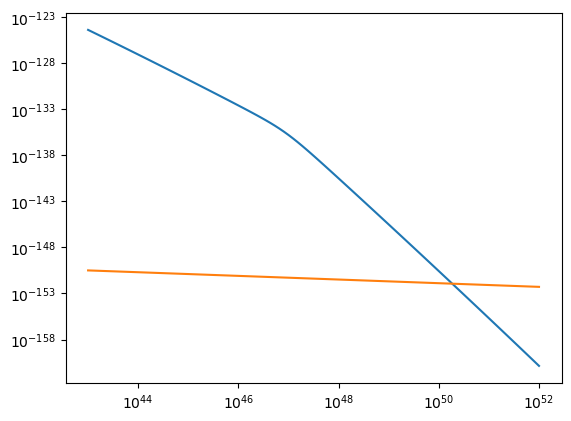

In [628]:
arr = np.logspace(43,52,100)
arr2=[phi_PLE(L,1,1e-6) for L in arr]
plt.plot(arr,arr2)
arr2=[phi_PLE(L,3.5,10) for L in arr]
plt.plot(arr,arr2)
plt.xscale('log')
plt.yscale('log')

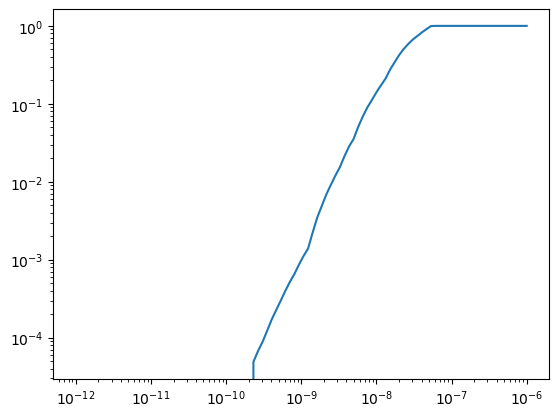

In [583]:
arr = np.logspace(-12,-6,100)
arr2=[new_fermi_func(F) for F in arr]
plt.plot(arr,arr2)
plt.xscale('log')
plt.yscale('log')

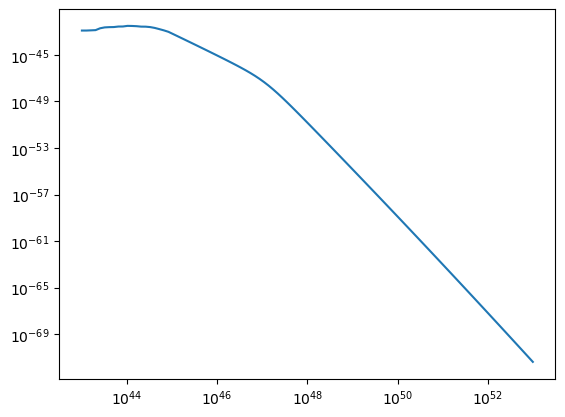

In [585]:
arr = np.logspace(43,53,100)
arr2=[dVdz(0.1) * phi_PLE(L, 2.5, 0.1) * new_fermi_func(flux(L, 2.5, 0.1, 6000)) for L in arr]
plt.plot(arr,arr2)
plt.xscale('log')
plt.yscale('log')

In [352]:
# res = dNdzPLE(10**48)
# print(res)
lum(2.2, 0.01, 6000)

6.43847932667428

In [374]:
Larr = np.logspace(43,52,256)

res_test = Parallel(n_jobs=-1)(delayed(dNdzTest)(L,0.3) for L in Larr)
# for i in range(len(Larr)):
#     res_test[i] = dNdzTest(Larr[i],0.05)

/var/folders/dj/8r1_x74n4kl0y3xdypfr3zq40000gn/T/ipykernel_26320/1625720371.py:73: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
/var/folders/dj/8r1_x74n4kl0y3xdypfr3zq40000gn/T/ipykernel_26320/1625720371.py:73: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
/var/folders/dj/8r1_x74n4kl0y3xdypfr3zq40000gn/T/ipykernel_26320/1625720371.py:73: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
/var/folders/dj/8r1_x74n4kl0y3xdypfr3zq40000gn/T/ipykernel_26320/1625720371.py:73: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
/var

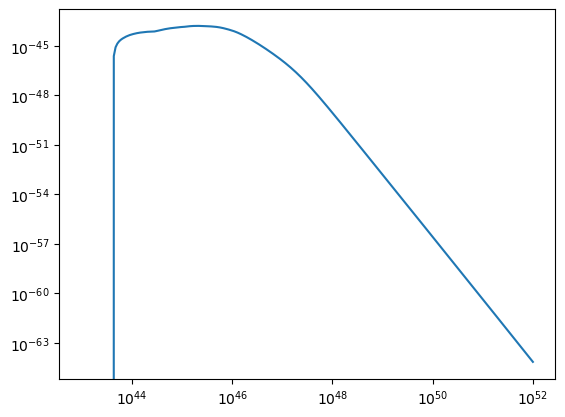

In [375]:
plt.plot(Larr,np.array(res_test))
plt.xscale('log')
plt.yscale('log')

In [381]:
interpolation_func = interp1d(
        Larr, res_test, kind="linear", fill_value="extrapolate"
    )
    
result_L, _ = quad(
    lambda L: interpolation_func(L), 1e43, 1e52,
    epsabs=0, epsrel=1e-13,
    limit=1000
)
print(result_L)

255.5221068936481


/var/folders/dj/8r1_x74n4kl0y3xdypfr3zq40000gn/T/ipykernel_26320/2822629551.py:5: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  result_L, _ = quad(


In [461]:
res_arr = np.zeros((26,256))
z_vals = np.sort(
    np.append(
        np.logspace(np.log10(6.6e-3),np.log10(3),25)
        ,.35)
    )
Larr = np.logspace(42,53,256)

for i, z in enumerate(z_vals):
    res_arr[i, :] = Parallel(n_jobs=-1)(delayed(dNdzTest)(L,z) for L in Larr)

/var/folders/dj/8r1_x74n4kl0y3xdypfr3zq40000gn/T/ipykernel_26320/1625720371.py:73: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
/var/folders/dj/8r1_x74n4kl0y3xdypfr3zq40000gn/T/ipykernel_26320/1625720371.py:73: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
/var/folders/dj/8r1_x74n4kl0y3xdypfr3zq40000gn/T/ipykernel_26320/1625720371.py:73: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
/var/folders/dj/8r1_x74n4kl0y3xdypfr3zq40000gn/T/ipykernel_26320/1625720371.py:73: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
/var

In [509]:
final_arr = np.zeros(26)

for i, z in enumerate(z_vals):
    interpolation_func = interp1d(
            Larr, res_arr[i,:], kind="linear"
        )
        
    result_L, _ = quad(
        lambda L: interpolation_func(L), 1e43, 1e51,
        epsabs=0, epsrel=1e-13,
        limit=100
    )

    final_arr[i] = result_L

/var/folders/dj/8r1_x74n4kl0y3xdypfr3zq40000gn/T/ipykernel_26320/776095481.py:8: IntegrationWarning: The maximum number of subdivisions (100) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  result_L, _ = quad(
/var/folders/dj/8r1_x74n4kl0y3xdypfr3zq40000gn/T/ipykernel_26320/776095481.py:8: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  result_L, _ = quad(


In [480]:
print(final_arr)
# print(z_vals[6])

[ 1.73653631e-09  3.00034770e-09  5.23890850e-09 -1.21883558e-11
 -2.18569699e-11 -4.00080410e-11 -7.51496807e-11 -1.45792270e-10
 -2.94376408e-10 -6.24117910e-10 -1.40279125e-09 -3.37366661e-09
 -8.78886240e-09  2.43825223e+02  2.45136948e+02  2.41031134e+02
  2.42228782e+02  2.42188997e+02  2.46335547e+02  2.46137881e+02
  2.38746023e+02  2.10222939e+02  1.56952540e+02  8.37128951e+01
  2.63691607e+01  3.71167065e+00]


1.8558311297463495e-69


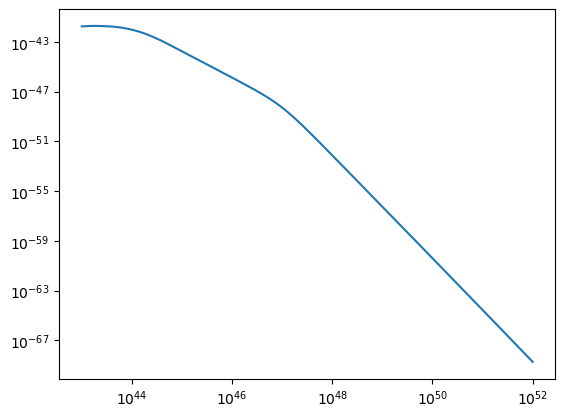

In [428]:
plt.plot(Larr, res_arr[6])
plt.xscale('log')
plt.yscale('log')
interpolation_func = interp1d(
    Larr, res_arr[6,:], kind="linear", fill_value="extrapolate"
        )
print(interpolation_func(1e52))

In [536]:
final_arr[0]

2.689427547015681

(1, 600)

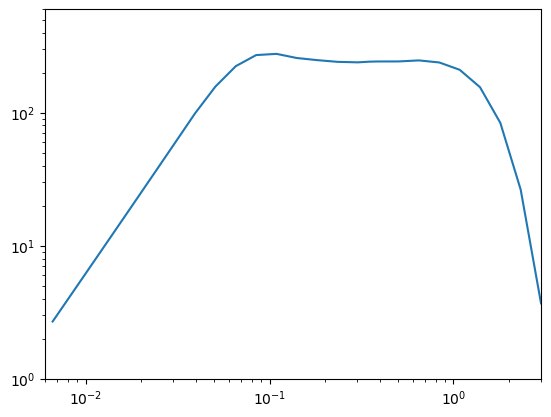

In [508]:
plt.plot(z_vals,final_arr)
plt.xscale('log')
plt.yscale('log')
plt.xlim([6e-3,3])
plt.ylim([1,600])

In [510]:
def dNdzTest2(L,z):
        result, _ = quad(
            lambda Gamma: dVdz(z) * phi_PLE(L, Gamma, z) * new_fermi_func(flux(L, Gamma, z, 6000)),
            1, 3,
            epsabs=1e-3, epsrel=1e-8,
            limit=100
        )
        return result

test2 = Parallel(n_jobs=-1)(delayed(dNdzTest2)(L,0.35) for L in Larr)

In [531]:
interpolation_func2 = interp1d(
        Larr, test2, kind="linear"
    )
    
result_L2, _2 = quad(
    lambda L: interpolation_func2(L), 7e43, 2e51,
    epsabs=1e-2, epsrel=1e-13,
    limit=100
)

print(result_L2)

241.75403847087765


/var/folders/dj/8r1_x74n4kl0y3xdypfr3zq40000gn/T/ipykernel_26320/3159226583.py:5: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  result_L2, _2 = quad(


In [521]:
print(len(res_arr[16:,]))

10


(1e-69, 1e-58)

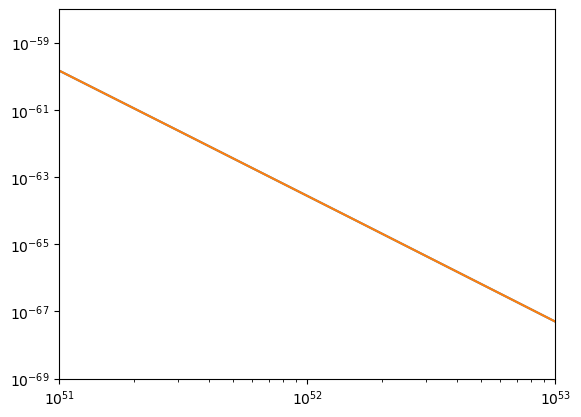

In [534]:
plt.plot(Larr,test2)
plt.plot(Larr,res_arr[16,:])
plt.xscale('log')
plt.yscale('log')
plt.xlim([1e51,1e53])
plt.ylim([1e-69,1e-58])

In [264]:
# Larr = np.logspace(43,52,100)
GAMMAarr = np.arange(1,3,.01)
fermiArr = np.zeros(len(GAMMAarr))

for i in range(len(GAMMAarr)):
    fermiArr[i] = new_fermi_func(flux(10**43, GAMMAarr[i], 0.05, 6000))

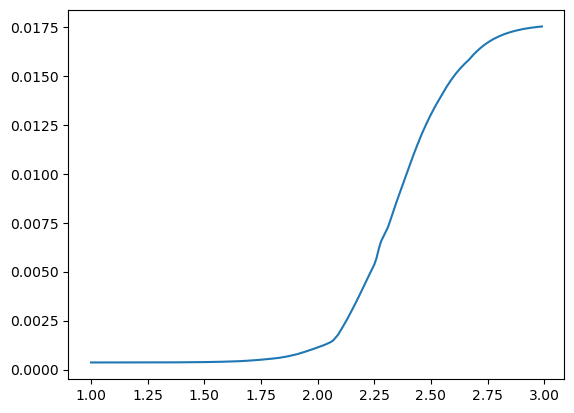

In [280]:
plt.plot(GAMMAarr,fermiArr)
# plt.xscale('log')
# plt.yscale('log')

In [337]:
res,_=quad(interp1d(Larr,dVdz(0.05)*np.array(res_test)),1e43,1e52,epsabs=0, epsrel=1e-13,
        limit=1000)
print(res)

1.9713441186366663


/var/folders/dj/8r1_x74n4kl0y3xdypfr3zq40000gn/T/ipykernel_26320/824999368.py:1: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  res,_=quad(interp1d(Larr,dVdz(0.05)*np.array(res_test)),1e43,1e52,epsabs=0, epsrel=1e-13,


In [229]:
fermiArrInterp = interp1d(Larr,fermiArr)
res, _ = quad(lambda L: fermiArrInterp(L),10**43,10**52)
print(res)

9.99999999e+51


# Second attempt: Doing a log change of variables

In [42]:
def log_dNdz_first(Gamma, z):
    result, _ = quad(
            lambda L: np.exp(L)*cd.diff_comoving_volume(z,**cosmo)*phi_PLE(np.exp(L), Gamma, z)* new_fermi_func(flux(np.exp(L), Gamma, z, 6000)),
            np.log(1e43), np.log(1e52),
            epsabs=0, epsrel=1e-3,
            limit=100
        )
    return result, _

In [43]:
def log_dNdz_second(z):
    Garr = np.linspace(1,3.5,256)
    res1 = Parallel(n_jobs=-1)(delayed(log_dNdz_first)(Gamma,z) for Gamma in Garr)
    res_arr = np.array(res1)[:,0]  # results from the first integral
    err_arr = np.array(res1)[:,1]  # error from the first integral
    
    first_int_func = interp1d(Garr, res_arr)
    
    result, _ = quad(
            lambda G: first_int_func(G), 1, 3.5,
            epsabs=0, epsrel=1e-3,
        )
    
    return result, _, err_arr

In [44]:
z_vals = np.logspace(np.log10(6.61e-3),np.log10(3),24)
dNdz_res_two_ints = [log_dNdz_second(z) for z in z_vals]

KeyboardInterrupt: 

In [46]:
def log_dNdz_PLE(z):
    result, _ = nquad(
        lambda L, G: np.exp(L) * cd.diff_comoving_volume(z,**cosmo)*(Mpc**3) * phi_PLE(np.exp(L), G, z) * new_fermi_func(flux(np.exp(L), G, z, 6000)),
        [[np.log(1e43),np.log(1e52)], [1, 3.5]], 
        opts={'epsabs': 0, 'epsrel': 1e-3, 'limit': 100}
    )
    
    return result,_

def log_dNdz_LDDE(z):
    result, _ = nquad(
        lambda L, G: np.exp(L) * dVdz(z) * phi_LDDE(np.exp(L), G, z) * new_fermi_func(flux(np.exp(L), G, z, 6000)),
        [[np.log(1e43),np.log(1e52)], [1, 3.5]], 
        opts={'epsabs': 0, 'epsrel': 1e-3, 'limit': 100}
    )
    
    return result,_

def log_dNdz_PDE(z):
    result, _ = nquad(
        lambda L, G: np.exp(L) * dVdz(z) * phi_PDE(np.exp(L), G, z) * new_fermi_func(flux(np.exp(L), G, z, 6000)),
        [[np.log(1e43),np.log(1e52)], [1, 3.5]], 
        opts={'epsabs': 0, 'epsrel': 1e-3, 'limit': 100}
    )
    
    return result,_

In [47]:
z_vals = np.logspace(np.log10(6.61e-3),np.log10(3),24)
dNdz_res_PLE = Parallel(n_jobs=-1)(delayed(log_dNdz_PLE)(z) for z in tqdm(z_vals, desc="Processing"))

Processing: 100%|███████████████████████████████| 24/24 [00:55<00:00,  2.31s/it]


In [162]:
dNdz_res_LDDE = Parallel(n_jobs=-1)(delayed(log_dNdz_LDDE)(z) for z in tqdm(z_vals, desc="Processing"))

Processing: 100%|███████████████████████████████| 24/24 [08:55<00:00, 22.33s/it]


In [163]:
dNdz_res_PDE = Parallel(n_jobs=-1)(delayed(log_dNdz_PDE)(z) for z in tqdm(z_vals, desc="Processing"))

Processing: 100%|███████████████████████████████| 24/24 [09:42<00:00, 24.26s/it]


In [54]:
np.array(dNdz_res_PLE)[:,0]*(Mpc**3)

array([ 5.46183428,  8.63186161, 12.39250743, 15.97709552, 18.73450801,
       20.35143335, 20.98990408, 20.91624334, 20.44850377, 19.81367345,
       19.16873611, 18.61004087, 18.21164851, 18.04526379, 18.16390888,
       18.58915109, 19.26730704, 19.98070321, 20.21224328, 19.02224927,
       15.30160327,  9.04756072,  3.04887436,  0.41262425])

In [56]:
arr = np.array(dNdz_res_PLE)[:,0]*(Mpc**3)

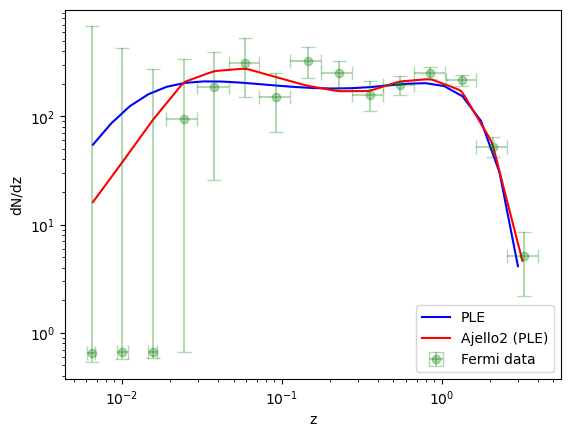

In [67]:
plt.plot(z_vals,np.array(dNdz_res_PLE)[:,0]*(Mpc**3)*10, color = 'blue', label = 'PLE')
# plt.plot(z_vals,np.array(dNdz_res_LDDE)[:,0], color = 'purple', label = 'LDDE')
# plt.plot(z_vals,np.array(dNdz_res_PDE)[:,0], color = 'cyan', label = 'PDE')
# plt.plot(z_vals,[col[0] for col in dNdz_res_two_ints])
plt.plot(dNdz_actual[:,0],dNdz_actual[:,1],color = 'red', label = 'Ajello2 (PLE)')
plt.errorbar(dNdz_x_vals, dNdz_y_vals, yerr=dNdz_y_err, xerr = dNdz_x_err, fmt='o', capsize=5, label='Fermi data',color = 'green',alpha = 0.3)
plt.xlabel('z')
plt.ylabel('dN/dz')
plt.xscale('log')
plt.yscale('log')
plt.legend()
# plt.ylim([70,350])

(70, 350)

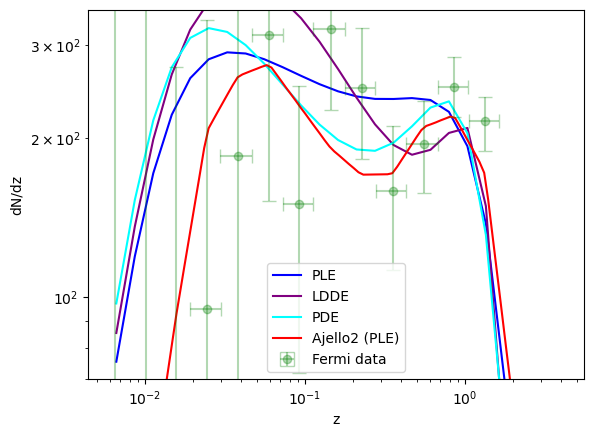

In [28]:
plt.plot(z_vals,np.array(dNdz_res_PLE)[:,0], color = 'blue', label = 'PLE')
plt.plot(z_vals,np.array(dNdz_res_LDDE)[:,0], color = 'purple', label = 'LDDE')
plt.plot(z_vals,np.array(dNdz_res_PDE)[:,0], color = 'cyan', label = 'PDE')
# plt.plot(z_vals,[col[0] for col in dNdz_res_two_ints])
plt.plot(dNdz_actual[:,0],dNdz_actual[:,1],color = 'red', label = 'Ajello2 (PLE)')
plt.errorbar(dNdz_x_vals, dNdz_y_vals, yerr=dNdz_y_err, xerr = dNdz_x_err, fmt='o', capsize=5, label='Fermi data',color = 'green',alpha = 0.3)
plt.xlabel('z')
plt.ylabel('dN/dz')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.ylim([70,350])

In [71]:
def log_dNdGamma_PLE(G):
    result, _ = nquad(
        lambda L, z: np.exp(L + z)* cd.diff_comoving_volume(np.exp(z),**cosmo)*((Mpc**3)*10) * phi_PLE(np.exp(L), G, np.exp(z)) * new_fermi_func(flux(np.exp(L), G, np.exp(z), 6000)),
        [[np.log(1e43),np.log(1e52)],[np.log(1e-3), np.log(6)]], 
        opts={'epsabs': 0, 'epsrel': 1e-2, 'limit': 100}
    )
    
    return result, _
    
def log_dNdGamma_LDDE(G):
    result, _ = nquad(
        lambda L, z: np.exp(L + z) * dVdz(np.exp(z)) * phi_LDDE(np.exp(L), G, np.exp(z)) * new_fermi_func(flux(np.exp(L), G, np.exp(z), 6000)),
        [[np.log(1e43),np.log(1e52)],[np.log(1e-3), np.log(6)]], 
        opts={'epsabs': 0, 'epsrel': 1e-2, 'limit': 100}
    )
    
    return result, _

def log_dNdGamma_PDE(G):
    result, _ = nquad(
        lambda L, z: np.exp(L + z) * dVdz(np.exp(z)) * phi_PDE(np.exp(L), G, np.exp(z)) * new_fermi_func(flux(np.exp(L), G, np.exp(z), 6000)),
        [[np.log(1e43),np.log(1e52)],[np.log(1e-3), np.log(6)]], 
        opts={'epsabs': 0, 'epsrel': 1e-2, 'limit': 100}
    )
    
    return result, _

In [72]:
Gamma_vals = np.linspace(1,3,24)
dNdGamma_res_PLE = Parallel(n_jobs=-1)(delayed(log_dNdGamma_PLE)(Gamma) for Gamma in tqdm(Gamma_vals, desc="Processing"))

Processing: 100%|███████████████████████████████| 24/24 [00:51<00:00,  2.14s/it]


In [167]:
dNdGamma_res_LDDE = Parallel(n_jobs=-1)(delayed(log_dNdGamma_LDDE)(Gamma) for Gamma in tqdm(Gamma_vals, desc="Processing"))

Processing: 100%|███████████████████████████████| 24/24 [15:10<00:00, 37.93s/it]


In [168]:
dNdGamma_res_PDE = Parallel(n_jobs=-1)(delayed(log_dNdGamma_PDE)(Gamma) for Gamma in tqdm(Gamma_vals, desc="Processing"))

Processing: 100%|███████████████████████████████| 24/24 [08:51<00:00, 22.14s/it]


(1.0, 3.0)

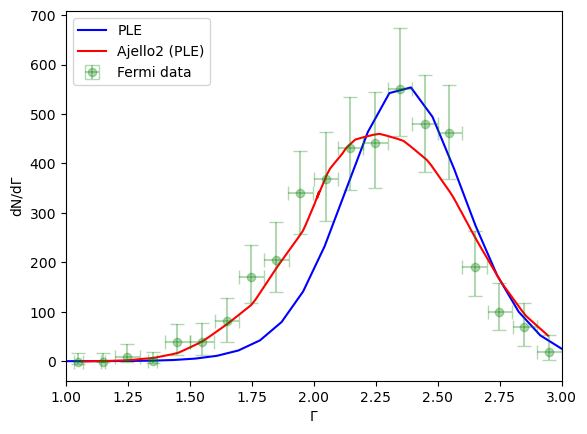

In [74]:
plt.plot(Gamma_vals, np.array(dNdGamma_res_PLE)[:,0], color = 'blue', label = 'PLE')
# plt.plot(Gamma_vals, np.array(dNdGamma_res_LDDE)[:,0], color = 'purple', label = 'LDDE')
# plt.plot(Gamma_vals, np.array(dNdGamma_res_PDE)[:,0], color = 'cyan', label = 'PDE')
# plt.plot(z_vals,[col[0] for col in dNdz_res_two_ints])
plt.plot(dNdGamma_actual[:,0],dNdGamma_actual[:,1],color = 'red', label = 'Ajello2 (PLE)')
plt.errorbar(dNdGamma_x_vals, dNdGamma_y_vals, yerr=dNdGamma_y_err, xerr=dNdGamma_x_err, fmt='o', capsize=5, label='Fermi data',color = 'green',alpha = 0.3)
plt.xlabel('Γ')
plt.legend()
plt.ylabel('dN/dΓ')
plt.xlim([1,3])

(1.0, 3.0)

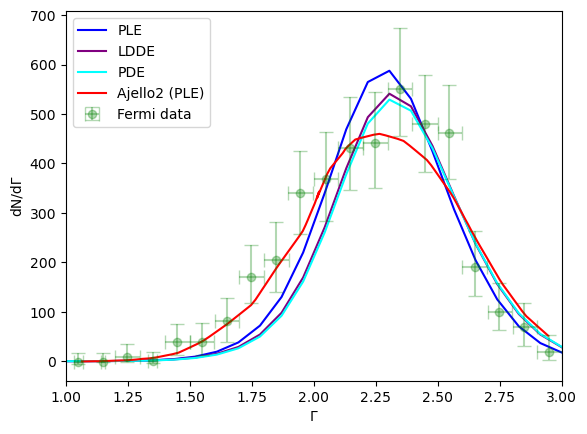

In [29]:
plt.plot(Gamma_vals, np.array(dNdGamma_res_PLE)[:,0], color = 'blue', label = 'PLE')
plt.plot(Gamma_vals, np.array(dNdGamma_res_LDDE)[:,0], color = 'purple', label = 'LDDE')
plt.plot(Gamma_vals, np.array(dNdGamma_res_PDE)[:,0], color = 'cyan', label = 'PDE')
# plt.plot(z_vals,[col[0] for col in dNdz_res_two_ints])
plt.plot(dNdGamma_actual[:,0],dNdGamma_actual[:,1],color = 'red', label = 'Ajello2 (PLE)')
plt.errorbar(dNdGamma_x_vals, dNdGamma_y_vals, yerr=dNdGamma_y_err, xerr=dNdGamma_x_err, fmt='o', capsize=5, label='Fermi data',color = 'green',alpha = 0.3)
plt.xlabel('Γ')
plt.legend()
plt.ylabel('dN/dΓ')
plt.xlim([1,3])

In [121]:
def log_dNdL_PLE(L):
    result, _ = nquad(
        lambda G, z: np.exp(z) * dVdz(np.exp(z)) * phi_PLE(L, G, np.exp(z)) * new_fermi_func(flux(L, G, np.exp(z), 6000)),
        [[1, 3.5], [np.log(1e-3), np.log(6)]], 
        opts={'epsabs': 0, 'epsrel': 1e-2, 'limit': 100}
    )
    
    return result,_

def log_dNdL_LDDE(L):
    result, _ = nquad(
        lambda z, G: dVdz(z) * phi_PLE(L, G, z) * new_fermi_func(flux(L, G, z, 6000)),
        [[1e-3, 6], [1, 3.5]], 
        opts={'epsabs': 0, 'epsrel': 1e-3, 'limit': 100}
    )
    
    return result,_

def log_dNdL_PDE(L):
    result, _ = nquad(
        lambda z, G: dVdz(z) * phi_PDE(L, G, z) * new_fermi_func(flux(L, G, z, 6000)),
        [[1e-3, 6], [1, 3.5]], 
        opts={'epsabs': 0, 'epsrel': 1e-3, 'limit': 100}
    )
    
    return result,_

In [119]:
log_dNdL_LDDE(1e44)

/var/folders/dj/8r1_x74n4kl0y3xdypfr3zq40000gn/T/ipykernel_10593/2817476814.py:52: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  result, _ = quad(lambda En: dNdEDPL(En * (1 + z), Gamma, Ecut) * expOpticalDepth(En * (1 + z), z),
/var/folders/dj/8r1_x74n4kl0y3xdypfr3zq40000gn/T/ipykernel_10593/2817476814.py:52: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  result, _ = quad(lambda En: dNdEDPL(En * (1 + z), Gamma, Ecut) * expOpticalDepth(En * (1 + z), z),


(6.552528979320866e-44, 9.33302133531194e-47)

In [122]:
L_vals = np.logspace(44, 49,24)
dNdL_res_PLE = Parallel(n_jobs=-1)(delayed(log_dNdL_PLE)(L) for L in tqdm(L_vals, desc="Processing"))

Processing:  33%|██████████▋                     | 8/24 [00:00<00:00, 67.37it/s]/var/folders/dj/8r1_x74n4kl0y3xdypfr3zq40000gn/T/ipykernel_10593/1231438647.py:52: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/var/folders/dj/8r1_x74n4kl0y3xdypfr3zq40000gn/T/ipykernel_10593/1231438647.py:52: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity)

In [126]:
flux(1e48,3,1,6000)

9.245851846623374e-08

In [ ]:
dNdL_res_PLE = Parallel(n_jobs=-1)(delayed(log_dNdL_PLE)(L) for L in tqdm(L_vals, desc="Processing"))

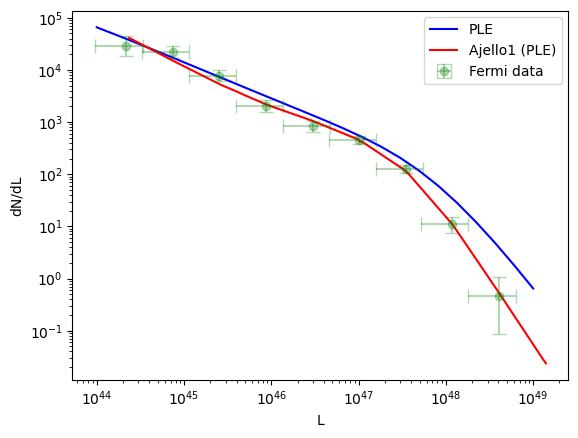

In [124]:
plt.plot(L_vals,np.array(dNdL_res_PLE)[:,0]*1e48, color = 'blue', label = 'PLE')
# plt.plot(L_vals,np.array(dNdL_res_LDDE)[:,0], color = 'purple', label = 'LDDE')
# plt.plot(L_vals,np.array(dNdL_res_PDE)[:,0], color = 'cyan', label = 'PDE')
plt.plot(dNdL_actual[:,0],dNdL_actual[:,1],color = 'red', label = 'Ajello1 (PLE)')
plt.errorbar(dNdL_x_vals, dNdL_y_vals, yerr=dNdL_y_err, xerr = dNdL_x_err, fmt='o', capsize=5, label='Fermi data',color = 'green',alpha = 0.3)
plt.xlabel('L')
plt.ylabel('dN/dL')
plt.xscale('log')
plt.yscale('log')
plt.legend()
# plt.ylim([3e-2,5e4])

In [907]:
# def flux_qu(L, Gamma, z, Ecut):
#     return L / ((1 + z)**(Gamma-2) * Eta(Gamma, z, 0.1, 100, Ecut) * 4 * np.pi * dl(z)**2)

In [42]:
def log_dNdz_qu_PLE(z):
    result, _ = nquad(
        lambda L, G: np.exp(L) * dVdz(z) * phi_PLE_qu(np.exp(L), G, z) * new_fermi_func_qu(fluxPL(np.exp(L), G, z, 6000)),
        [[np.log(4e40),np.log(1e50)], [1.4, 3]], 
        opts={'epsabs': 0, 'epsrel': 1e-3, 'limit': 100}
    )
    
    return result,_

def log_dNdz_qu_LDDE(z):
    result, _ = nquad(
        lambda L, G: np.exp(L) * dVdz(z) * phi_LDDE_qu(np.exp(L), G, z) * new_fermi_func_qu(fluxPL(np.exp(L), G, z, 6000)),
        [[np.log(4e40),np.log(1e50)], [1.4, 3]], 
        opts={'epsabs': 0, 'epsrel': 1e-3, 'limit': 100}
    )
    
    return result,_

def log_dNdz_qu_PDE(z):
    result, _ = nquad(
        lambda L, G: np.exp(L) * dVdz(z) * phi_PDE_qu(np.exp(L), G, z) * new_fermi_func_qu(fluxPL(np.exp(L), G, z, 6000)),
        [[np.log(4e40),np.log(1e50)], [1.4, 3]], 
        opts={'epsabs': 0, 'epsrel': 1e-3, 'limit': 100}
    )
    
    return result,_

In [43]:
z_vals = np.logspace(np.log10(6.61e-3),np.log10(3),24)
dNdz_res_qu_PLE = Parallel(n_jobs=-1)(delayed(log_dNdz_qu_PLE)(z) for z in tqdm(z_vals, desc="Processing"))

Processing: 100%|███████████████████████████████| 24/24 [06:47<00:00, 16.99s/it]
/var/folders/dj/8r1_x74n4kl0y3xdypfr3zq40000gn/T/ipykernel_10593/2817476814.py:74: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


In [44]:
dNdz_res_qu_LDDE = Parallel(n_jobs=-1)(delayed(log_dNdz_qu_LDDE)(z) for z in tqdm(z_vals, desc="Processing"))

Processing: 100%|███████████████████████████████| 24/24 [06:11<00:00, 15.48s/it]
/var/folders/dj/8r1_x74n4kl0y3xdypfr3zq40000gn/T/ipykernel_10593/2817476814.py:74: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


In [45]:
dNdz_res_qu_PDE = Parallel(n_jobs=-1)(delayed(log_dNdz_qu_PDE)(z) for z in tqdm(z_vals, desc="Processing"))

Processing: 100%|███████████████████████████████| 24/24 [05:11<00:00, 12.97s/it]
/var/folders/dj/8r1_x74n4kl0y3xdypfr3zq40000gn/T/ipykernel_10593/2817476814.py:74: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


(0.01, 5)

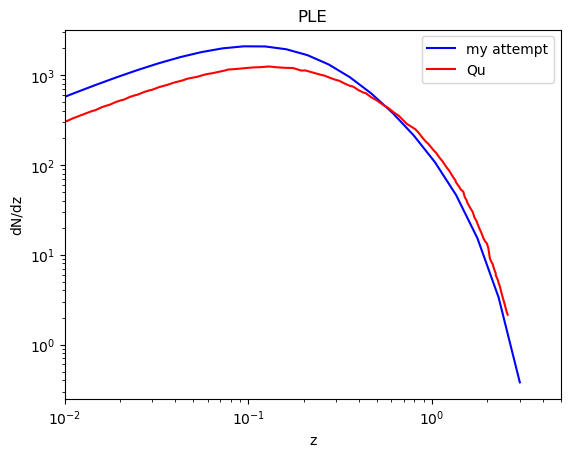

In [46]:
# multiplyed by 10.28 sr because that's the total sky coverage of fermi (maybe)
plt.plot(z_vals,np.array(dNdz_res_qu_PLE)[:,0], color = 'blue',label='my attempt')
plt.plot(dNdz_ple_qu[:,0],dNdz_ple_qu[:,1],color = 'red',label='Qu')
# plt.errorbar(dNdz_x_vals, dNdz_y_vals, yerr=dNdz_y_err, xerr=dNdz_x_err, fmt='o', capsize=5, label='Mid Points with Error Bars',color = 'green',alpha = 0.3)
plt.xlabel('z')
plt.ylabel('dN/dz')
plt.xscale('log')
plt.yscale('log')
plt.title('PLE')
plt.legend()
# plt.ylim([70,1500])
plt.xlim([1e-2,5])

(0.01, 5)

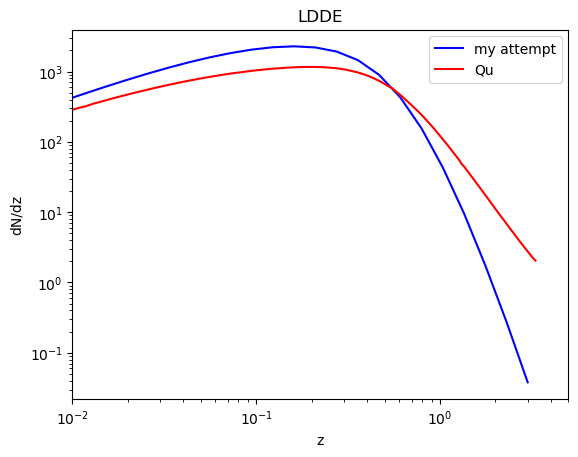

In [47]:
# multiplyed by 10.28 sr because that's the total sky coverage of fermi (maybe)
plt.plot(z_vals,np.array(dNdz_res_qu_LDDE)[:,0], color = 'blue',label='my attempt')
plt.plot(dNdz_ldde_qu[:,0],dNdz_ldde_qu[:,1],color = 'red',label='Qu')
# plt.errorbar(dNdz_x_vals, dNdz_y_vals, yerr=dNdz_y_err, xerr=dNdz_x_err, fmt='o', capsize=5, label='Mid Points with Error Bars',color = 'green',alpha = 0.3)
plt.xlabel('z')
plt.ylabel('dN/dz')
plt.xscale('log')
plt.yscale('log')
plt.title('LDDE')
plt.legend()
# plt.ylim([70,1500])
plt.xlim([1e-2,5])

(0.01, 5)

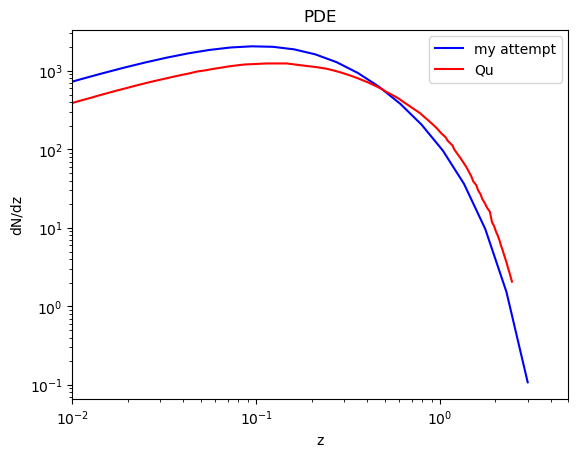

In [48]:
plt.plot(z_vals,np.array(dNdz_res_qu_PDE)[:,0], color = 'blue',label='my attempt')
plt.plot(dNdz_pde_qu[:,0],dNdz_pde_qu[:,1],color = 'red',label='Qu')
# plt.errorbar(dNdz_x_vals, dNdz_y_vals, yerr=dNdz_y_err, xerr=dNdz_x_err, fmt='o', capsize=5, label='Mid Points with Error Bars',color = 'green',alpha = 0.3)
plt.xlabel('z')
plt.ylabel('dN/dz')
plt.xscale('log')
plt.yscale('log')
plt.title('PDE')
plt.legend()
# plt.ylim([70,1500])
plt.xlim([1e-2,5])

In [71]:
def log_dNdGamma_qu_PLE(G):
    result, _ = nquad(
        lambda L, z: np.exp(L) * dVdz(z) * phi_PLE_qu(np.exp(L), G, z) * new_fermi_func_qu(fluxPL(np.exp(L), G, z, 6000)),
        [[np.log(4e40),np.log(1e50)], [0,6]], 
        opts={'epsabs': 0, 'epsrel': 1e-2, 'limit': 100}
    )
    
    return result,_

def log_dNdGamma_qu_LDDE(G):
    result, _ = nquad(
        lambda L, z: np.exp(L) * dVdz(z) * phi_LDDE_qu(np.exp(L), G, z) * new_fermi_func_qu(fluxPL(np.exp(L), G, z, 6000)),
        [[np.log(4e40),np.log(1e50)], [0,6]], 
        opts={'epsabs': 0, 'epsrel': 1e-2, 'limit': 100}
    )
    
    return result,_

def log_dNdGamma_qu_PDE(G):
    result, _ = nquad(
        lambda L, z: np.exp(L) * dVdz(z) * phi_PDE_qu(np.exp(L), G, z) * new_fermi_func_qu(fluxPL(np.exp(L), G, z, 6000)),
        [[np.log(4e40),np.log(1e50)], [0, 6]], 
        opts={'epsabs': 0, 'epsrel': 1e-2, 'limit': 100}
    )
    
    return result,_

In [72]:
Gamma_vals = np.linspace(1,3,24)
dNdGamma_res_qu_PLE = Parallel(n_jobs=-1)(delayed(log_dNdGamma_qu_PLE)(z) for z in tqdm(z_vals, desc="Processing"))

Processing:  33%|██████████▋                     | 8/24 [00:00<00:00, 65.28it/s]/var/folders/dj/8r1_x74n4kl0y3xdypfr3zq40000gn/T/ipykernel_10593/2817476814.py:74: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/var/folders/dj/8r1_x74n4kl0y3xdypfr3zq40000gn/T/ipykernel_10593/2817476814.py:74: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity)

KeyboardInterrupt: 

In [62]:
dNdGamma_res_qu_LDDE = Parallel(n_jobs=-1)(delayed(log_dNdGamma_qu_LDDE)(z) for z in tqdm(z_vals, desc="Processing"))

Processing:   0%|                                        | 0/24 [00:00<?, ?it/s]/var/folders/dj/8r1_x74n4kl0y3xdypfr3zq40000gn/T/ipykernel_10593/3281893173.py:13: RuntimeWarning: divide by zero encountered in log
/var/folders/dj/8r1_x74n4kl0y3xdypfr3zq40000gn/T/ipykernel_10593/2817476814.py:74: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
/var/folders/dj/8r1_x74n4kl0y3xdypfr3zq40000gn/T/ipykernel_10593/3281893173.py:13: RuntimeWarning: divide by zero encountered in log
/var/folders/dj/8r1_x74n4kl0y3xdypfr3zq40000gn/T/ipykernel_10593/3281893173.py:13: RuntimeWarning: divide by zero encountered in log
/var/folders/dj/8r1_x74n4kl0y3xdypfr3zq40000gn/T/ipykernel_10593/3281893173.py:13: RuntimeWarning: divide by zero encountered in log
/var/folders/dj/8r1_x74n4kl0y3xdypfr3zq40000gn/T/ipykernel_10593/3281893173.py:13: RuntimeWarning: divide by zero encountered in log
/var/f

In [63]:
dNdGamma_res_qu_PDE = Parallel(n_jobs=-1)(delayed(log_dNdGamma_qu_PDE)(z) for z in tqdm(z_vals, desc="Processing"))

Processing:   0%|                                        | 0/24 [00:00<?, ?it/s]/var/folders/dj/8r1_x74n4kl0y3xdypfr3zq40000gn/T/ipykernel_10593/3281893173.py:22: RuntimeWarning: divide by zero encountered in log
/var/folders/dj/8r1_x74n4kl0y3xdypfr3zq40000gn/T/ipykernel_10593/2817476814.py:74: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
/var/folders/dj/8r1_x74n4kl0y3xdypfr3zq40000gn/T/ipykernel_10593/3281893173.py:22: RuntimeWarning: divide by zero encountered in log
/var/folders/dj/8r1_x74n4kl0y3xdypfr3zq40000gn/T/ipykernel_10593/3281893173.py:22: RuntimeWarning: divide by zero encountered in log
/var/folders/dj/8r1_x74n4kl0y3xdypfr3zq40000gn/T/ipykernel_10593/3281893173.py:22: RuntimeWarning: divide by zero encountered in log
/var/folders/dj/8r1_x74n4kl0y3xdypfr3zq40000gn/T/ipykernel_10593/3281893173.py:22: RuntimeWarning: divide by zero encountered in log
/var/f

In [ ]:
plt.plot(Gamma_vals,1/1000*np.array(dNdGamma_res_qu_PLE)[:,0], color = 'blue',label='my attempt')
plt.plot(dNdG_ple_qu[:,0],dNdG_ple_qu[:,1],color = 'red',label='Qu')
# plt.errorbar(dNdz_x_vals, dNdz_y_vals, yerr=dNdz_y_err, xerr=dNdz_x_err, fmt='o', capsize=5, label='Mid Points with Error Bars',color = 'green',alpha = 0.3)
plt.xlabel('z')
plt.ylabel('dN/dz')
plt.xscale('log')
plt.yscale('log')
plt.title('PDE')
plt.legend()
# plt.ylim([70,1500])
# plt.xlim([1e-2,5])

In [ ]:
dNdG